In [1]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from imblearn import under_sampling, over_sampling
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.under_sampling import ClusterCentroids
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [2]:
train= pd.read_csv("train.csv")
test = pd.read_csv('test.csv')

In [3]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
train.info

<bound method DataFrame.info of             id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0            1    Male   44                1         28.0                   0   
1            2    Male   76                1          3.0                   0   
2            3    Male   47                1         28.0                   0   
3            4    Male   21                1         11.0                   1   
4            5  Female   29                1         41.0                   1   
...        ...     ...  ...              ...          ...                 ...   
381104  381105    Male   74                1         26.0                   1   
381105  381106    Male   30                1         37.0                   1   
381106  381107    Male   21                1         30.0                   1   
381107  381108  Female   68                1         14.0                   0   
381108  381109    Male   46                1         29.0                   0

In [5]:
train.isnull().sum(axis = 0)

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

# Data Preparation

In [6]:
train.head(3)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1


## exploratory data analysis

### Jumlah tiap respon dari tiap gender 
Dari semua gender, mayoritas responnya tertarik dengan penawaran asuransi kendaraan.

In [7]:
Male = train[train["Gender"] == "Male"]

In [8]:
Female = train[train["Gender"] == "Female"]

In [9]:
print(pd.pivot_table(train,index="Gender",columns = 'Response',values = 'id',aggfunc = 'count', observed = True))

Response       0      1
Gender                 
Female    156835  18185
Male      177564  28525


Male      206089
Female    175020
Name: Gender, dtype: int64


Response       0      1
Gender                 
Female    156835  18185
Male      177564  28525


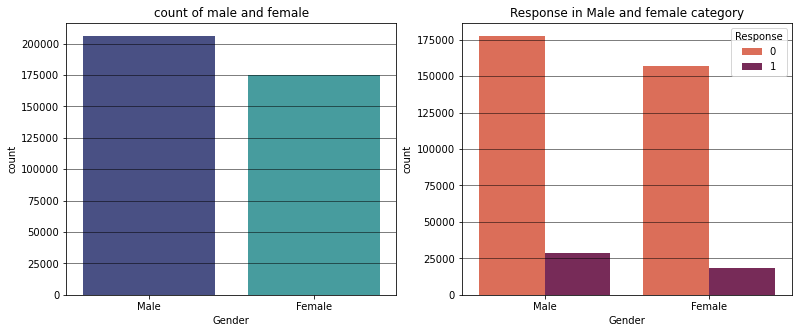

In [10]:
print(train["Gender"].value_counts())
print("\n")
print(pd.pivot_table(train,index="Gender",columns = 'Response',values = 'id',aggfunc = 'count', observed = True))

plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
sns.countplot(train['Gender'],palette="mako")
plt.title("count of male and female")
plt.grid(axis = 'y', linewidth=0.5, color='black')

plt.subplot(1,2,2)
plt.grid(axis = 'y', linewidth=0.5, color='black')
sns.countplot(train['Gender'], hue = train['Response'],palette="rocket_r")
plt.title("Response in Male and female category")
plt.show()

### Jumlah pelanggan berdasarkan kepemilikan asuransi kendaraan
mayoritas belum memiliki asuransi kendaraan.

                        id
Previously_Insured        
0                   206481
1                   174628


[Text(0.5, 1.0, 'kepemilikan asuransi kendaraan menurut Jenis Kelamin')]

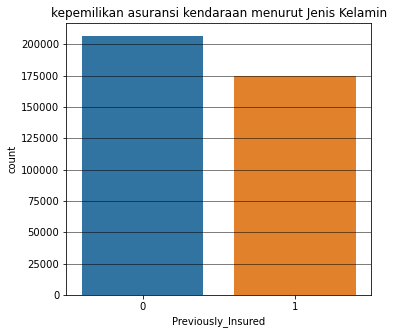

In [11]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.grid(axis = 'y', linewidth=0.5, color='black')
print(pd.pivot_table(train,index="Previously_Insured",values = 'id',aggfunc = 'count', observed = True))
sns.countplot(train.Previously_Insured).set(title='kepemilikan asuransi kendaraan menurut Jenis Kelamin')

### Kepemilikan SIM berdasarkan gender

   Gender  Driving_License
0  Female           175020
1    Male           206089


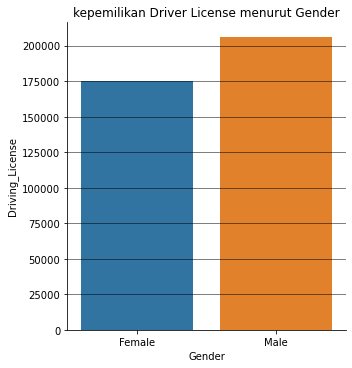

In [12]:
df = train.groupby(['Gender'])['Driving_License'].count().to_frame().reset_index()
print(df)

sns.catplot(x="Gender", y="Driving_License", data=df, kind="bar").set(title='kepemilikan Driver License menurut Gender')
plt.grid(axis = 'y', linewidth=0.5, color='black')

### Jumlah riwayat kerusakan pada kendaraan


                    id
Vehicle_Damage        
No              188696
Yes             192413


<AxesSubplot:xlabel='Vehicle_Damage', ylabel='count'>

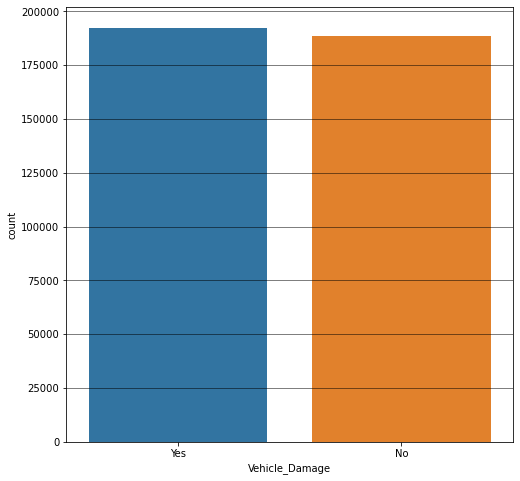

In [13]:
plt.figure(figsize = (8,8))
plt.grid(axis = 'y', linewidth=0.5, color='black')
print(pd.pivot_table(train,index="Vehicle_Damage",values = 'id',aggfunc = 'count', observed = True))
sns.countplot(train.Vehicle_Damage)

### Jumlah kendaraan berdasarkan usia kendaraannya

                 id
Vehicle_Age        
1-2 Year     200316
< 1 Year     164786
> 2 Years     16007


[Text(0.5, 1.0, 'Banyaknya Kendaraan Berdasarkan Umur-nya')]

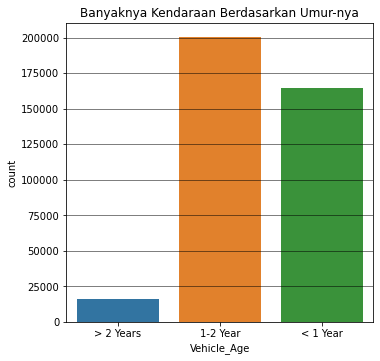

In [14]:
plt.figure(figsize = (5.5,5.5))
plt.grid(axis = 'y', linewidth=0.5, color='black')
print(pd.pivot_table(train,index="Vehicle_Age",values = 'id',aggfunc = 'count', observed = True))
sns.countplot(train.Vehicle_Age).set(title='Banyaknya Kendaraan Berdasarkan Umur-nya')

### Riwayat kerusakan kendaraan berdasarkan usia kendaraan
kendaraan yang memiliki riwayat kerusakan paling banyak kendaraan dengan usia 1-2 tahun

Vehicle_Damage      No     Yes
Vehicle_Age                   
1-2 Year         72091  128225
< 1 Year        116590   48196
> 2 Years           15   15992


[Text(0.5, 1.0, 'Jumlah Kerusakan Kendaraan Berdasarkan Umurnya')]

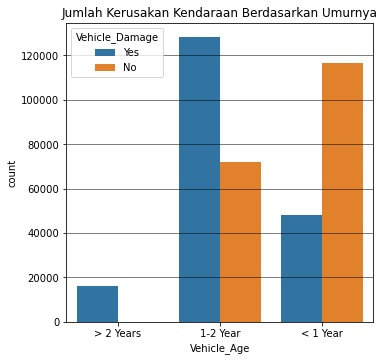

In [15]:
plt.figure(figsize = (5.5,5.5))
plt.grid(axis = 'y', linewidth=0.5, color='black')
print(pd.pivot_table(train,index="Vehicle_Age",columns = 'Vehicle_Damage',values = 'id',aggfunc = 'count', observed = True))
sns.countplot(data=train,x='Vehicle_Age',hue='Vehicle_Damage').set(title = 'Jumlah Kerusakan Kendaraan Berdasarkan Umurnya')

### Jumlah tiap respon pada tiap usia kendaraan
yang paling banyak tertarik dengan asuransi yang ditawarkan adalah pelanggan dengan pemilik kendaraan yang usia kendaraannya 1-2 tahun

In [16]:
df=train.groupby(['Vehicle_Age','Response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()
df

,Vehicle_Age,Response,count
0,1-2 Year,0,165510
1,1-2 Year,1,34806
2,< 1 Year,0,157584
3,< 1 Year,1,7202
4,> 2 Years,0,11305
5,> 2 Years,1,4702


Response          0      1
Vehicle_Age               
1-2 Year     165510  34806
< 1 Year     157584   7202
> 2 Years     11305   4702


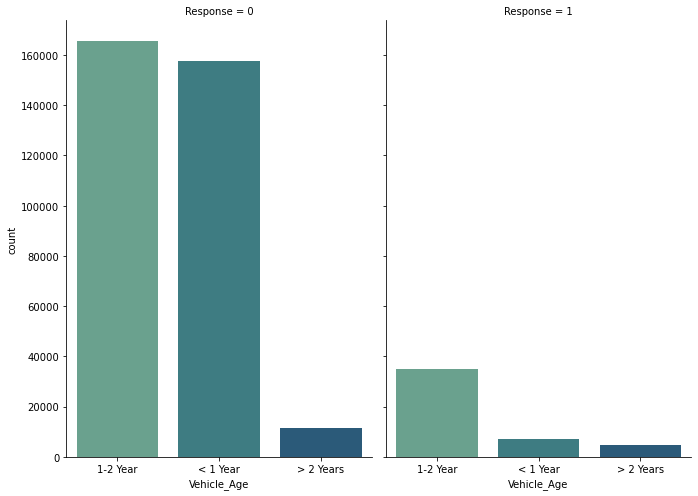

In [17]:
sns.catplot(x="Vehicle_Age", y="count",col="Response", data=df, kind="bar",height=7, aspect=.7, palette="crest")
print(pd.pivot_table(train,index="Vehicle_Age",columns = 'Response',values = 'id',aggfunc = 'count', observed = True))

In [18]:
a=pd.pivot_table(train,index = train['Response'],values = 'Response', aggfunc = 'count', observed = True)
a

,Response
Response,
0,334399
1,46710


          Response
Response          
0           334399
1            46710


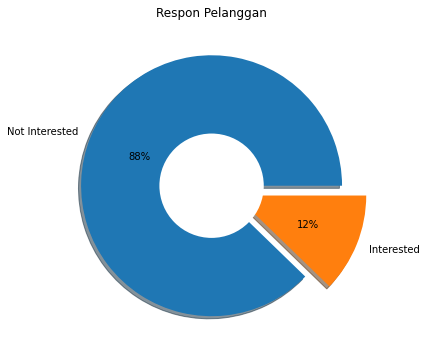

In [19]:
fig = plt.figure(figsize=(6,6))
print(a)

ax = plt.axes()
ax.pie(a['Response'], labels = ['Not Interested', 'Interested'], autopct='%1.0f%%', explode = [0,0.2],pctdistance=0.6,shadow = True)
centre_circle = plt.Circle((0, 0), 0.40, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax.set_title('Respon Pelanggan')
plt.show()

## feature engineering

In [20]:
columns = ['id']
train.drop(columns, inplace=True, axis=1)

In [21]:
train

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...
381104,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


### encoding categorikal

#### usia kendaraan
mengganti value dari kolom Vehicle_Age menjadi integer

In [22]:
train['Vehicle_Age'].replace({'< 1 Year':0,'1-2 Year':1,'> 2 Years':2}, inplace=True)
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,2,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,2,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,0,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,0,No,27496.0,152.0,39,0


In [23]:
train

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,2,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,2,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,0,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,0,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...
381104,Male,74,1,26.0,1,1,No,30170.0,26.0,88,0
381105,Male,30,1,37.0,1,0,No,40016.0,152.0,131,0
381106,Male,21,1,30.0,1,0,No,35118.0,160.0,161,0
381107,Female,68,1,14.0,0,2,Yes,44617.0,124.0,74,0


#### Vehicle_Damage
mengganti value dari kolom Vehicle_Damage menjadi integer

In [24]:
train['Vehicle_Damage'].replace({'Yes':1,'No':0}, inplace=True)

#### Gender
mengganti value dari kolom Gender menjadi integer

In [25]:
train['Gender']=train['Gender'].replace({'Male':1,'Female':0})
train.head(3)

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,44,1,28.0,0,2,1,40454.0,26.0,217,1
1,1,76,1,3.0,0,1,0,33536.0,26.0,183,0
2,1,47,1,28.0,0,2,1,38294.0,26.0,27,1


### outlier & Distribusi
Menapilkan outlier dan distribusi pada kolom Age dan Annual Premium, dua kolom tersebut tidak perlu dihandling outlier dan distribution karna akan menggunakan model XGBoost

[Text(0.5, 1.0, 'Distribusi Kolom Age')]

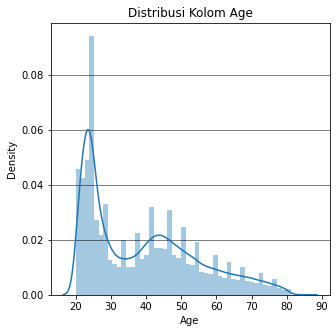

In [26]:
plt.figure(figsize = (5,5))
plt.grid(axis = 'y', linewidth=0.5, color='black')
sns.distplot(train['Age']).set(title='Distribusi Kolom Age')

[Text(0.5, 1.0, 'Boxplot Kolom Age')]

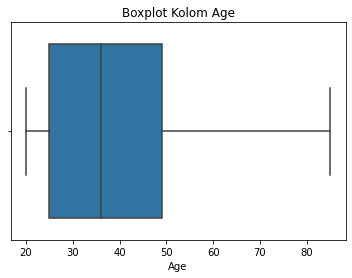

In [27]:
sns.boxplot(x=train["Age"]).set(title='Boxplot Kolom Age')

[Text(0.5, 1.0, 'Boxplot Kolom Annual_Premium')]

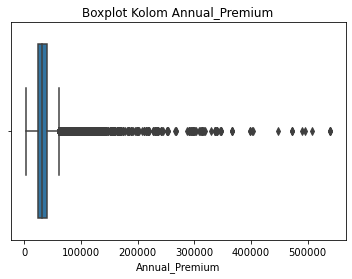

In [28]:
plt.figure(figsize = (6,4))
plt.grid(axis = 'y', linewidth=0.5, color='black')
sns.boxplot(x = train['Annual_Premium']).set(title='Boxplot Kolom Annual_Premium')

[Text(0.5, 1.0, 'Distribusi Kolom Annual_Premium')]

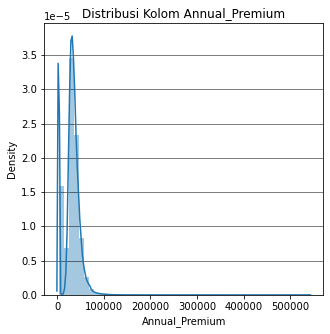

In [29]:
plt.figure(figsize = (5,5))
plt.grid(axis = 'y', linewidth=0.5, color='black')


sns.distplot(train['Annual_Premium']).set(title='Distribusi Kolom Annual_Premium')

# Modeling

## Baseline model

### Imbalanced handling
menggunakan undersampling untuk menyeimbangkan data

In [30]:
train['Response'].value_counts()

0    334399
1     46710
Name: Response, dtype: int64

In [31]:
X = train.drop(['Response'],axis=1)
y = train['Response']
X_under, y_under = under_sampling.RandomUnderSampler().fit_resample(X, y)

df_undersampling = pd.concat([X_under, y_under], axis=1)
df_undersampling.head(3)
df_undersampling.shape

(93420, 11)

In [32]:
y_under.value_counts()

0    46710
1    46710
Name: Response, dtype: int64

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.3, random_state=13)

### ujicoba model xgboost dengan menggunkan hyperparameter default

In [34]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)
pred_xgb = model_xgb.predict(X_test) 
accuracy_xgb = accuracy_score(y_test, pred_xgb)
print("Accuracy:" ,accuracy_xgb)

[21:55:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.7953329051594947


### model XGBOOST dengan tuned hyperparameter


In [35]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [36]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [37]:
params = {'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 100,
        'seed': 0,
          'learning_rate': hp.quniform('learning_rate', 0.01, 0.2, 0.01)
    }

In [38]:
def objective(space):
    clf=XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [(X_train, y_train), (X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric=['error','logloss'],
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE Akurasi:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [39]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = params,
                        algo = tpe.suggest,
                        max_evals = 30,
                        trials = trials)

SCORE Akurasi:                                        
0.7966887889816598                                    
SCORE Akurasi:                                                                   
0.7945122386355526                                                               
SCORE Akurasi:                                                                   
0.7976521801184614                                                               
SCORE Akurasi:                                                                   
0.7963676586027261                                                               
SCORE Akurasi:                                                                   
0.7961892528366517                                                               
SCORE Akurasi:                                                                   
0.7970456005138086                                                               
SCORE Akurasi:                                                        

In [40]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.9451759925133482, 'gamma': 3.010111106436402, 'learning_rate': 0.12, 'max_depth': 7.0, 'min_child_weight': 6.0, 'reg_alpha': 49.0, 'reg_lambda': 0.42174790184867905}


Setelah best hyperparameter didapatkan, lalu digunakan pada parameter XGBoost, dan menghasilkan accuracy yang lebih tinggi dibandingan accurasi XGBoost dengan hyperparameter default

In [58]:
model_xgb_bestparams = XGBClassifier(colsample_bytree= 0.6867988935946676, gamma= 2.0672479277514437, learning_rate= 0.2, 
                                     max_depth= 13, min_child_weight= 10, reg_alpha= 53.0, 
                                     reg_lambda= 0.8698526815895538,n_estimators = 100 )
eval_set = [(X_train, y_train),(X_test,y_test)]
model_xgb_bestparams.fit(X_train, y_train,eval_metric=['error','logloss'],eval_set = eval_set)

pred_xgb = model_xgb_bestparams.predict(X_test) 
predictions_xgb = [round(value) for value in pred_xgb]
accuracy_xgb = accuracy_score(y_test, predictions_xgb)
print("Accuracy:" ,accuracy_xgb)

[0]	validation_0-error:0.21707	validation_0-logloss:0.62368	validation_1-error:0.21737	validation_1-logloss:0.62372
[1]	validation_0-error:0.21516	validation_0-logloss:0.57868	validation_1-error:0.21541	validation_1-logloss:0.57862
[2]	validation_0-error:0.20800	validation_0-logloss:0.54073	validation_1-error:0.21002	validation_1-logloss:0.54085
[3]	validation_0-error:0.20626	validation_0-logloss:0.52966	validation_1-error:0.20788	validation_1-logloss:0.52983
[4]	validation_0-error:0.20448	validation_0-logloss:0.50580	validation_1-error:0.20634	validation_1-logloss:0.50584
[5]	validation_0-error:0.20448	validation_0-logloss:0.48915	validation_1-error:0.20545	validation_1-logloss:0.48908
[6]	validation_0-error:0.20678	validation_0-logloss:0.48413	validation_1-error:0.20613	validation_1-logloss:0.48402
[7]	validation_0-error:0.20641	validation_0-logloss:0.47164	validation_1-error:0.20595	validation_1-logloss:0.47167
[8]	validation_0-error:0.20591	validation_0-logloss:0.46309	validation_1

#### hyperparameter dan metric evaluasi

In [42]:
metrics.recall_score(y_test,predictions_xgb)

0.9317564670573103

In [43]:
metrics.roc_auc_score(y_test,predictions_xgb)

0.7974061696746072

In [44]:
metrics.precision_score(y_test, predictions_xgb)

0.7338886700061913

In [45]:
confusion_matrix(y_test,predictions_xgb)

array([[ 9304,  4728],
       [  955, 13039]], dtype=int64)

In [46]:
y_xgb_prob = model_xgb_bestparams.predict_proba(X_test)
y_xgb_prob = y_xgb_prob[:,1]

In [47]:
fprxgb,tprxgb,thresholds_xgb = metrics.roc_curve(y_test,y_xgb_prob)

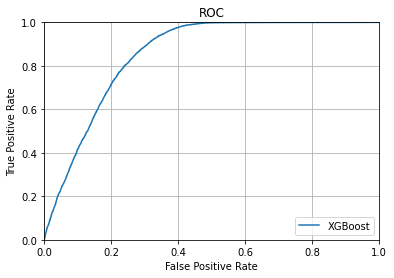

In [48]:
plt.plot(fprxgb,tprxgb, label = 'XGBoost')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc = "lower right")
plt.title("ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)

### model analysis (improve model)

In [49]:
from xgboost import plot_tree,plot_importance
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import graphviz

#### cross validation

In [50]:
kfold = KFold(n_splits=10)
result = cross_val_score(model_xgb_bestparams,X_train, y_train,cv=kfold)
print('akurasi cross validation = %.2f%%(%.2f%%)' %(result.mean()*100,result.std()*100))

[21:56:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:56:07] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:56:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:56:12] WARNING:

In [51]:
print('akurasi cross validation = %.2f%%(%.2f%%)' %(result.mean()*100,result.std()*100))

akurasi cross validation = 79.64%(0.43%)


#### overfitting check

In [52]:
results = model_xgb_bestparams.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0,epochs)

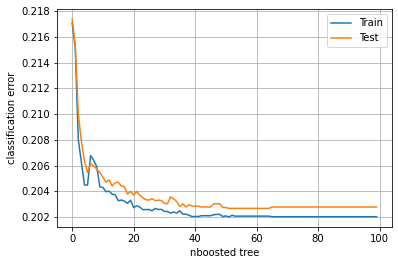

In [53]:
plt.plot(x_axis,results['validation_0']['error'],label='Train')
plt.plot(x_axis,results['validation_1']['error'],label='Test')
plt.legend()
plt.ylabel('classification error')
plt.xlabel('nboosted tree')
plt.grid(True)

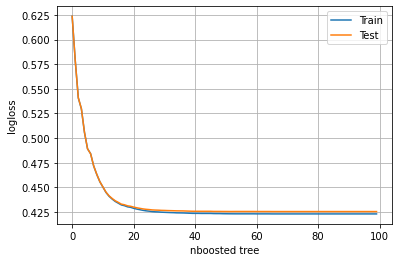

In [54]:
plt.plot(x_axis,results['validation_0']['logloss'],label='Train')
plt.plot(x_axis,results['validation_1']['logloss'],label='Test')
plt.legend()
plt.ylabel('logloss')
plt.xlabel('nboosted tree')
plt.grid(True)

Berdasarkan grafik, terlihat tidak ada overfitting

#### feature importance 

Text(0, 0.5, 'F_Score')

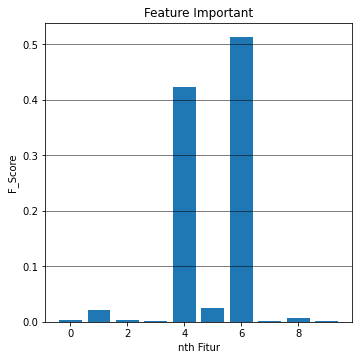

In [55]:
plt.figure(figsize = (5.5,5.5))
plt.grid(axis = 'y', linewidth=0.5, color='black')
plt.bar(range(len(model_xgb_bestparams.feature_importances_)),model_xgb_bestparams.feature_importances_)
plt.title('Feature Important')
plt.xlabel("nth Fitur")
plt.ylabel("F_Score")

Berdasarkan grafik feature importance yang berisi kolom fitur, didapatkan kolom Previously_Insured dan Vehicle_Damage paling berpengaruh dalam pemodelan untuk memprediksi respon pelanggan

Mulai dari memuat dataset untuk memahami data terlebih dahulu, kemudian melakukan Exploratory data analysis, data cleaning, data manipulation dan encoding. Setelah itu mengatasi imbalanced handling dengan menggunakan metode under sampling lalu uji coba menggunakan model XGBoost dengan hyperparameter default dan menghasilkan akurasi 79.5%. Kemudian menguji model xgboost dengan tuned hyperparameter dan mendapatkan skor 79,6%. Dari hasil hyperparameter yang mendapatkan metric evaluasi, didapatkan recall dengan skor 0.927852708199529, ROC_AUC dengan skor 0.7927638621280241, precision dengan skor 0.7304904769930896. Dari hasil confusion matrix yang perlu diperharikan adalah False Negative yaitu ketika response pelanggan diprediksi tidak tertarik tetapi sebenarnya pelanggan tersebut tertarik. Untuk mengevaluasi kinerja model dilakukan cross validation yang menghasilkan akurasi 79.48%. Dan hasilnya tidak jauh beda dengan akurasi dari model XGBoost yang menggunakan hyperparameter. Berdasarkan hasil pemeriksaan overfitting, tidak terdapat overfitting pada hasil pemodelan dapat dilihat dari grafik yang ada. Berdasarkan kepentingan fitur, kolom Previous_Insured & Vehicle_Damage adalah kolom fitur yang paling berpengaruh dalam pemodelan prediktif. Model prediksi ini dapat digunakan untuk memperkirakan response customer Terhadap produk asuransi yang baru.